In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import List

In [ ]:
def gd(grad_f, f, x0, max_iters, tol, t_fixed, bt_alpha, bt_beta):
    x = x0
    trajectory = [x.copy()]
    for k in range(1, max_iters + 1):
        grad = grad_f(x)
        if t_fixed is not None:
            t = t_fixed   # Do not use backtracking
        else:
            t_bt = 1      # Opted to use backtracking
            while f(x-t_bt*grad) > f(x) - bt_alpha*t_bt*np.linalg.norm(grad, ord=2)**2:
                t_bt *= bt_beta
            t = t_bt
        x_new = x - t * grad
        trajectory.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return np.array(trajectory)

def gd_hbm(grad_f, f, x0, max_iters, tol, hbm_alpha, hbm_beta):
    x = x0
    y = x0  # At each step, y is the momentum retaining point corresponding to x.
    trajectory = [x.copy()]
    for k in range(1, max_iters + 1):
        grad = grad_f(x)
        x_new = y - hbm_alpha * grad
        y = x_new + hbm_beta * (x_new - x)
        trajectory.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return np.array(trajectory)

# Define Conjugate Gradient Method
def conjugate_gradient(f, grad_f, x0, max_iters, tol):
    x = x0.copy()
    g = grad_f(x)
    d = -g
    trajectory = [x.copy()]
    for k in range(max_iters):
        alpha = -(g @ d) / (d @ (grad_f(x + 1e-5 * d) - g) / 1e-5)
        x_new = x + alpha * d
        g_new = grad_f(x_new)
        beta = (g_new @ g_new) / (g @ g)
        d = -g_new + beta * d
        trajectory.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
        g = g_new
    return np.array(trajectory)

# Define Nesterov Accelerated Gradient Descent with Tseng parameters and backtracking line search
def gd_nesterov1(grad_f, f, x0, max_iters, tol, bt_alpha, bt_beta):
    x = x0
    y = x0
    trajectory = [x.copy()]
    for k in range(1, max_iters + 1):
        grad = grad_f(y)

        t = 1      # Opted to use backtracking
        while f(y-t*grad) > f(y) - bt_alpha*t*np.linalg.norm(grad, ord=2)**2:
            t *= bt_beta
        x_new = y - t * grad
        y = x_new + (k - 1) / (k + 2) * (x_new - x)
        trajectory.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return np.array(trajectory)

In [1]:
def generate(P: np.ndarray, q: np.ndarray, r: np.ndarray):
  f = lambda x: 0.5 * x.T @ P @ x + q.T @ x + r
  grad_f = lambda x: P @ x + q
  return (f, grad_f)

NameError: name 'np' is not defined

In [ ]:
def plot_results(Q, xs, title,GDtype):
    """Generates the required plots."""
    x_vals, y_vals = xs[:, 0], xs[:, 1]

    # Contour plot
    plt.figure(figsize=(6, 5))
    X, Y = np.meshgrid(np.linspace(-0.1, 0.15, 100), np.linspace(-0.15, 0.15, 100))
    Z = 0.5 * (Q[0, 0] * X**2 + 2 * Q[0, 1] * X * Y + Q[1, 1] * Y**2)
    plt.contour(X, Y, Z, levels=20)
    plt.plot(x_vals, y_vals, 'ro-', label=f"{GDtype} path")
    plt.xlim(-0.1, 0.15)   # Zoom to show detailed path
    plt.ylim(-0.15, 0.15)
    plt.title(f"{GDtype}: {title}")
    plt.legend()
    plt.show()

    # Function value vs iterations
    f_values = [0.5 * x.T @ Q @ x for x in xs]
    plt.figure()
    plt.plot(range(len(f_values)), f_values, 'bo-')
    plt.xlabel("Iteration")
    plt.ylabel("Function Value")
    plt.title(f"Function Value vs Iterations({GDtype}): {title}")
    plt.show()

    # Gradient norm vs iterations
    f, grad = generate(Q,np.array([0, 0]),0)
    grad_norms = [np.linalg.norm(grad(x)) for x in xs]
    plt.figure()
    plt.plot(range(len(grad_norms)), grad_norms, 'go-')
    plt.xlabel("Iteration")
    plt.ylabel("Gradient Norm")
    plt.title(f"Gradient Norm vs Iterations({GDtype}): {title}")
    plt.show()

1.0
50.0


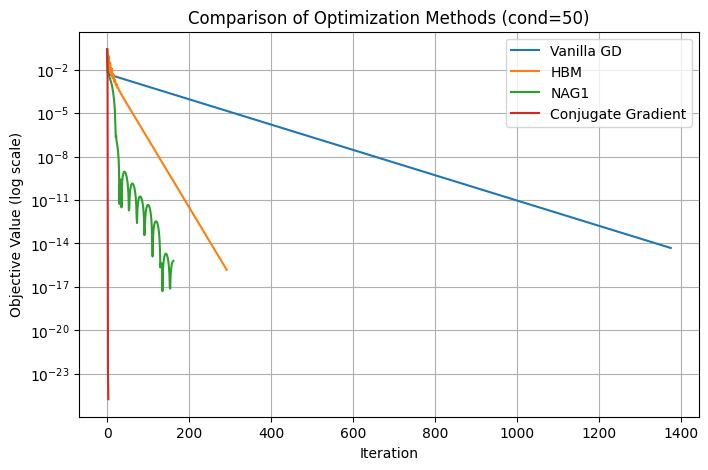

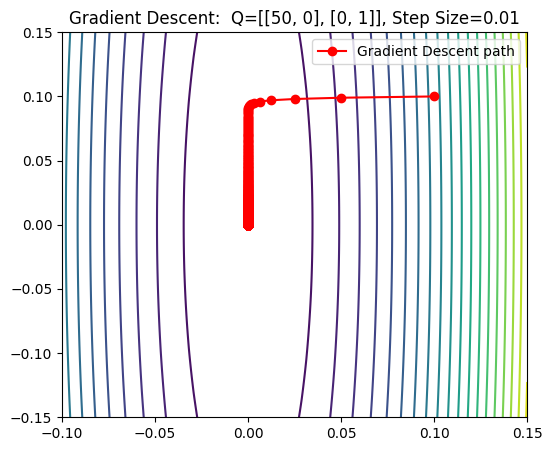

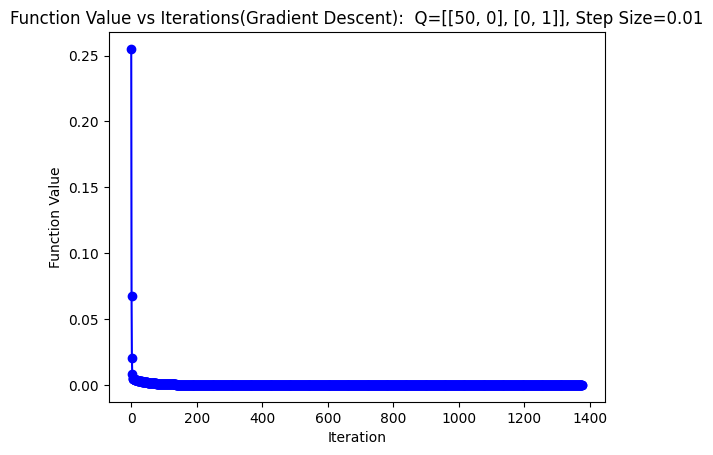

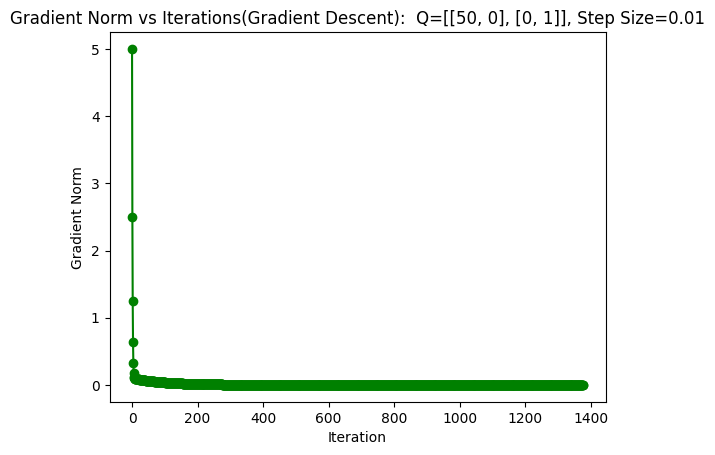

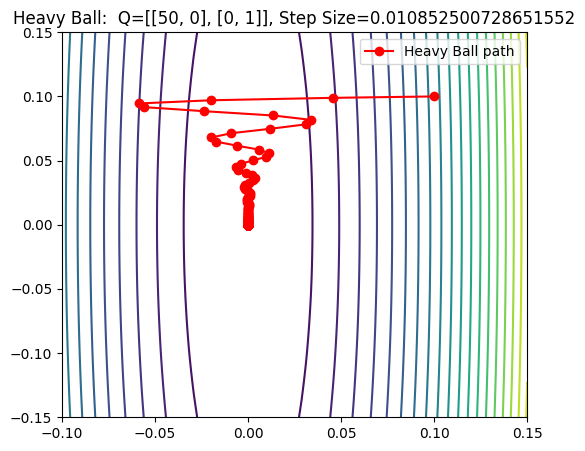

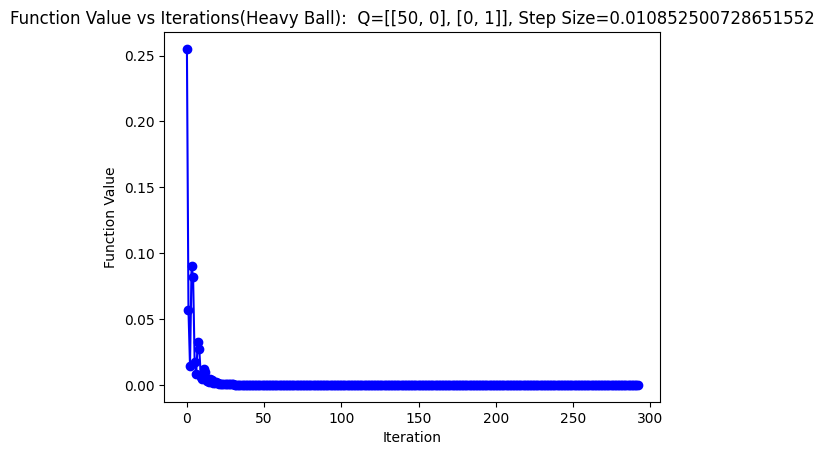

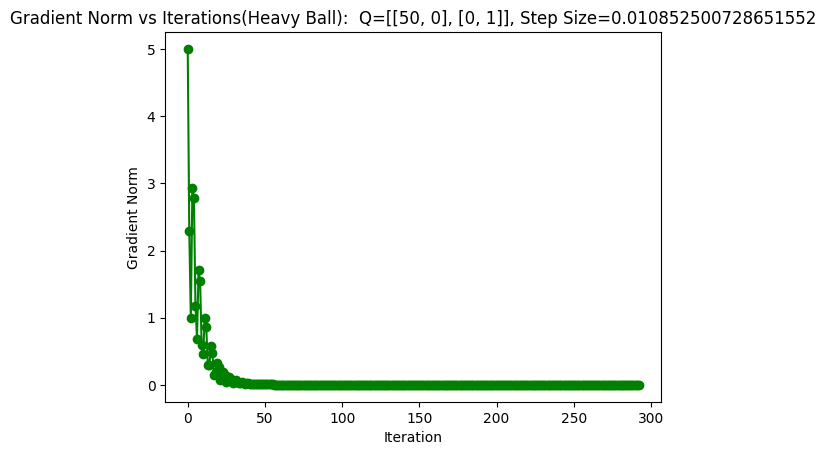

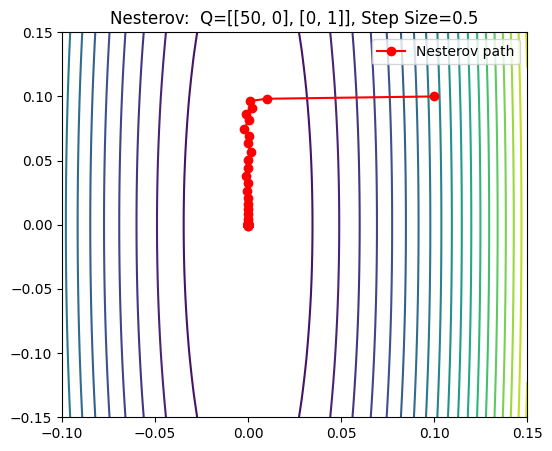

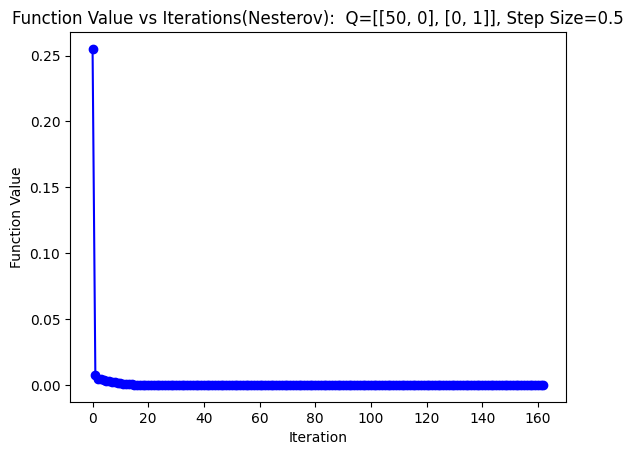

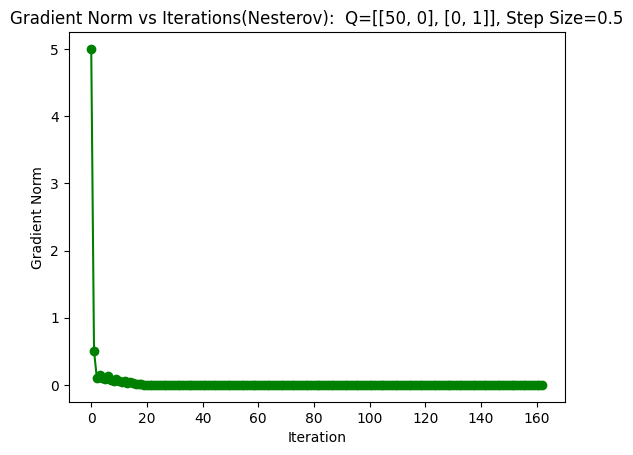

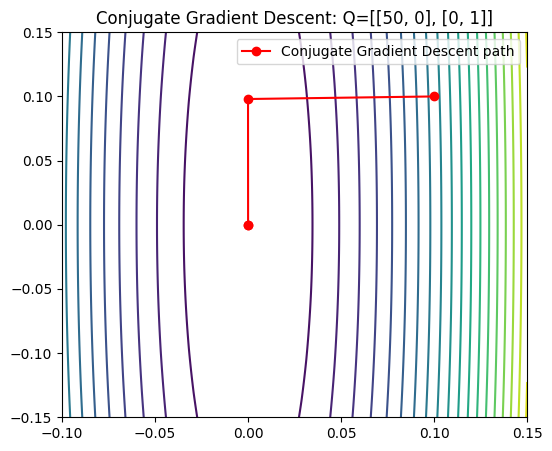

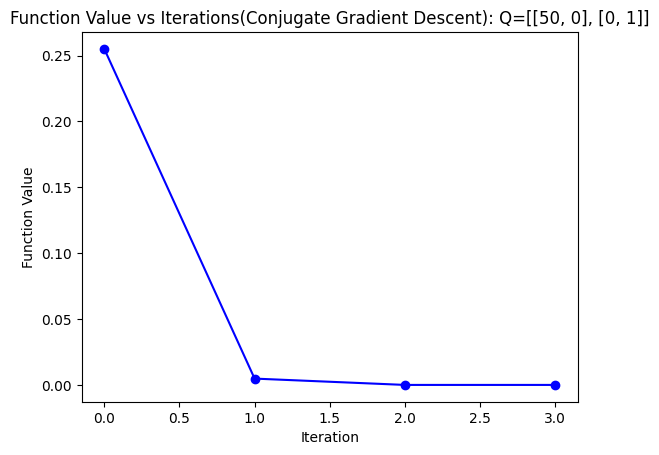

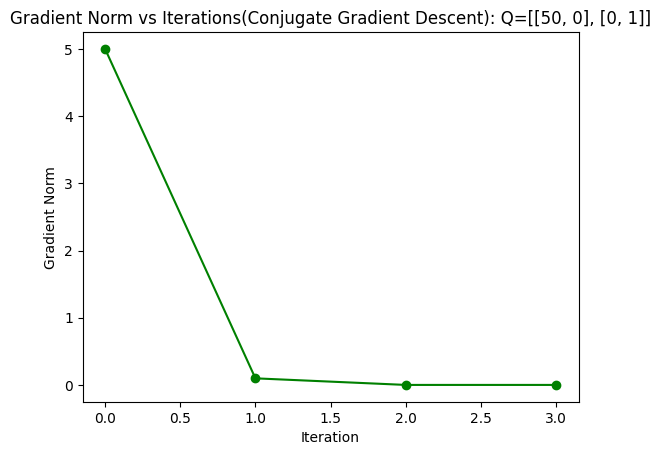

In [ ]:
# Note: Condition number will affect the performance of a learning rate!!
x0_scaled = np.array([0.1,0.1])
Q_moderate_cond = np.array([[50, 0], [0, 1]])  # condition number = 50 (Largest eval / smallest eval)
q_mod = np.array([0, 0])
r_mod = 0

f_mod, grad_mod = generate(Q_moderate_cond, q_mod, r_mod)
x0_mod = x0_scaled

# FIRST: We need to figure out the parameters for Heavy Ball Method (HBM):
eigenvalues = np.linalg.eigvals(Q_moderate_cond)
lambda_min = np.min(eigenvalues)
lambda_max = np.max(eigenvalues)
print(lambda_min)
print(lambda_max)
hbm_alpha = 4 / (np.sqrt(lambda_max) - np.sqrt(lambda_min))**2
hbm_beta = (np.sqrt(lambda_max) - np.sqrt(lambda_min)) / (np.sqrt(lambda_max) + np.sqrt(lambda_min))

# run all the methods
tol = 1e-9; max_iters = 10000;

# Vanilla GD with backtracking
x_gd_mod = gd(grad_mod, f_mod, x0_mod, max_iters, tol, 0.01, 0.0001, 0.5)
f_gd_mod = np.apply_along_axis(f_mod, 1, x_gd_mod)

# Heavy ball method with optimal parameters:
x_hbm_mod = gd_hbm(grad_mod, f_mod, x0_mod, max_iters, tol, 0.1 * hbm_alpha, hbm_beta)
f_hbm_mod = np.apply_along_axis(f_mod, 1, x_hbm_mod)

# Nesterov with momentum = (k-1)/(k+2) (Tseng)
x_nag1_mod = gd_nesterov1(grad_mod, f_mod, x0_mod, max_iters, tol, 0.5, 0.8)
f_nag1_mod = np.apply_along_axis(f_mod, 1, x_nag1_mod)

# Conjugate
x_cg_mod = conjugate_gradient(f_mod, grad_mod, x0_mod, max_iters, tol)
f_cg_mod = np.apply_along_axis(f_mod, 1, x_cg_mod)

plt.figure(figsize=(8, 5))
plt.plot(f_gd_mod, label="Vanilla GD")
plt.plot(f_hbm_mod, label="HBM")
plt.plot(f_nag1_mod, label="NAG1")
plt.plot(f_cg_mod, label="Conjugate Gradient")
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Objective Value (log scale)")
plt.title("Comparison of Optimization Methods (cond=50)")
plt.legend()
plt.grid(True)
plt.show()

plot_results(Q_moderate_cond, x_gd_mod, f" Q={Q_moderate_cond.tolist()}, Step Size={0.01}","Gradient Descent")
plot_results(Q_moderate_cond, x_hbm_mod, f" Q={Q_moderate_cond.tolist()}, Step Size={0.1 * hbm_alpha}","Heavy Ball")
plot_results(Q_moderate_cond, x_nag1_mod, f" Q={Q_moderate_cond.tolist()}, Step Size={ 0.5}","Nesterov")
plot_results(Q_moderate_cond, x_cg_mod, f"Q={Q_moderate_cond.tolist()}","Conjugate Gradient Descent")


In [ ]:
x_gd_mod

array([[1.00000000e-01, 1.00000000e-01],
       [5.00000000e-02, 9.90000000e-02],
       [2.50000000e-02, 9.80100000e-02],
       ...,
       [0.00000000e+00, 1.00636929e-07],
       [0.00000000e+00, 9.96305601e-08],
       [0.00000000e+00, 9.86342545e-08]])